# Урок 2. Обзор основных алгоритмов машинного обучения, используемых в соревнованиях
Домашнее задание

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - `ROC AUC`, целевая переменная - `isFraud`.

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

##### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
%matplotlib inline

In [68]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Задания основные

### Подготовка данных

##### Загрузка данных

In [4]:
train = pd.read_csv('./data/assignment2_data/assignment_2_train.csv')
# test = pd.read_csv('./data/assignment2_data/assignment_2_test.csv')
target = 'isFraud'

print("train.shape = {} rows, {} cols".format(*train.shape))
# print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols


##### Разделим  признаки `train` на числовые и категориальные

In [5]:
all_features = train.drop(target, axis=1)
numerical_features = train.select_dtypes(include=[np.number]).drop(target, axis=1)
categorical_features = train.select_dtypes(include=[np.object])
categorical_features = categorical_features.astype('category')

print(f'count of all features in = {all_features.shape[1]}')
print(f"count of numeric features = {numerical_features.shape[1]}")
print(f"count of categorical features = {categorical_features.shape[1]}")

count of all features in = 393
count of numeric features = 379
count of categorical features = 14


##### Разделим numerical_features на x_train и x_valid

In [6]:
# x_train_num
x_train_num, x_valid_num, y_train_num, y_valid_num = \
        train_test_split(numerical_features, train[target], train_size=0.8, random_state=42)

In [7]:
# x_train_num_cat
num_cat_features = pd.concat([numerical_features, categorical_features], axis=1)

x_train_num_cat, x_valid_num_cat, y_train_num_cat, y_valid_num_cat = \
        train_test_split(num_cat_features, train[target], train_size=0.8, random_state=42)

##### Сделаем get_dummies и добавим категориальные признаки к числовым

In [8]:
categorical_features_2 = categorical_features.copy()

for col in ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
    categorical_features_2[col] = categorical_features_2[col].map({'T': 0, 'F': 1})
    categorical_features_2[col] = categorical_features_2[col].astype('float')
    
num_cat_features_dummies = pd.concat([numerical_features, 
                                      pd.get_dummies(categorical_features_2)], axis=1)

x_train_num_cat_dummies, x_valid_num_cat_dummies, y_train_num_cat_dummies, y_valid_num_cat_dummies = \
        train_test_split(num_cat_features_dummies, train[target], train_size=0.8, random_state=42)

### XGBoost

#### Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром `booster=gbtree`. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [9]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [10]:
model_xgb_numeric = xgb.XGBClassifier(**params)
model_xgb_numeric.fit(X=x_train_num,
                      y=y_train_num,
                      eval_set=[(x_train_num, y_train_num), (x_valid_num, y_valid_num)],
                      early_stopping_rounds=50,
                      eval_metric="auc",
                      verbose=20)

[0]	validation_0-auc:0.65232	validation_1-auc:0.63974
[20]	validation_0-auc:0.82254	validation_1-auc:0.81751
[40]	validation_0-auc:0.87410	validation_1-auc:0.86886
[60]	validation_0-auc:0.88985	validation_1-auc:0.88052
[80]	validation_0-auc:0.89506	validation_1-auc:0.88571
[100]	validation_0-auc:0.89986	validation_1-auc:0.89033
[120]	validation_0-auc:0.90421	validation_1-auc:0.89389
[140]	validation_0-auc:0.90699	validation_1-auc:0.89598
[160]	validation_0-auc:0.90934	validation_1-auc:0.89814
[180]	validation_0-auc:0.91030	validation_1-auc:0.89892
[200]	validation_0-auc:0.91030	validation_1-auc:0.89892
[220]	validation_0-auc:0.91030	validation_1-auc:0.89892


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [11]:
model_xgb_numeric_and_cat = xgb.XGBClassifier(**params)
model_xgb_numeric_and_cat.fit(X=x_train_num_cat_dummies,
                              y=y_train_num_cat_dummies,
                              eval_set=[(x_train_num_cat_dummies,
                                         y_train_num_cat_dummies),
                                        (x_valid_num_cat_dummies,
                                         y_valid_num_cat_dummies)],
                              early_stopping_rounds=50,
                              eval_metric="auc",
                              verbose=20)

[0]	validation_0-auc:0.65232	validation_1-auc:0.63974
[20]	validation_0-auc:0.82278	validation_1-auc:0.81779
[40]	validation_0-auc:0.87642	validation_1-auc:0.86819
[60]	validation_0-auc:0.89552	validation_1-auc:0.88377
[80]	validation_0-auc:0.90255	validation_1-auc:0.89074
[100]	validation_0-auc:0.90862	validation_1-auc:0.89589
[120]	validation_0-auc:0.91320	validation_1-auc:0.89994
[140]	validation_0-auc:0.91603	validation_1-auc:0.90254
[160]	validation_0-auc:0.91712	validation_1-auc:0.90365
[180]	validation_0-auc:0.91712	validation_1-auc:0.90365
[199]	validation_0-auc:0.91712	validation_1-auc:0.90365


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### LightGBM

#### Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [12]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 5000,
    "n_jobs": 6,
    "seed": 27
}

In [13]:
model_lgb_numeric = lgb.LGBMClassifier(**params)
model_lgb_numeric.fit(X=x_train_num,
                      y=y_train_num,
                      eval_set=[(x_train_num, y_train_num), 
                                (x_valid_num, y_valid_num)],
                      early_stopping_rounds=30,
                      eval_metric="auc",
                      verbose=20)

Training until validation scores don't improve for 30 rounds
[20]	training's auc: 0.841194	valid_1's auc: 0.833322
[40]	training's auc: 0.870331	valid_1's auc: 0.86328
[60]	training's auc: 0.880724	valid_1's auc: 0.870946
[80]	training's auc: 0.884452	valid_1's auc: 0.873292
[100]	training's auc: 0.890733	valid_1's auc: 0.880059
[120]	training's auc: 0.895094	valid_1's auc: 0.883657
[140]	training's auc: 0.901101	valid_1's auc: 0.888727
[160]	training's auc: 0.90501	valid_1's auc: 0.892693
[180]	training's auc: 0.907912	valid_1's auc: 0.895344
[200]	training's auc: 0.910985	valid_1's auc: 0.898356
[220]	training's auc: 0.913397	valid_1's auc: 0.899755
[240]	training's auc: 0.916111	valid_1's auc: 0.901534
[260]	training's auc: 0.918819	valid_1's auc: 0.903648
[280]	training's auc: 0.92173	valid_1's auc: 0.905785
[300]	training's auc: 0.924639	valid_1's auc: 0.907984
[320]	training's auc: 0.927717	valid_1's auc: 0.910176
[340]	training's auc: 0.931666	valid_1's auc: 0.911509
[360]	train

[2960]	training's auc: 0.991758	valid_1's auc: 0.952592
[2980]	training's auc: 0.991877	valid_1's auc: 0.952664
[3000]	training's auc: 0.992023	valid_1's auc: 0.952772
[3020]	training's auc: 0.992162	valid_1's auc: 0.95291
[3040]	training's auc: 0.992272	valid_1's auc: 0.952982
[3060]	training's auc: 0.99248	valid_1's auc: 0.953091
[3080]	training's auc: 0.992601	valid_1's auc: 0.953116
[3100]	training's auc: 0.992685	valid_1's auc: 0.9532
[3120]	training's auc: 0.992764	valid_1's auc: 0.953243
[3140]	training's auc: 0.992825	valid_1's auc: 0.95327
[3160]	training's auc: 0.992927	valid_1's auc: 0.953373
[3180]	training's auc: 0.99302	valid_1's auc: 0.953441
[3200]	training's auc: 0.993122	valid_1's auc: 0.953507
[3220]	training's auc: 0.993212	valid_1's auc: 0.95356
[3240]	training's auc: 0.99327	valid_1's auc: 0.953624
[3260]	training's auc: 0.993351	valid_1's auc: 0.95369
[3280]	training's auc: 0.993423	valid_1's auc: 0.953745
[3300]	training's auc: 0.993485	valid_1's auc: 0.953834
[

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=5000, n_jobs=6,
               objective='binary', seed=27)

#### Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [14]:
model_lgb_numeric_and_cat = lgb.LGBMClassifier(**params)
model_lgb_numeric_and_cat.fit(X=x_train_num_cat_dummies,
                              y=y_train_num_cat_dummies,
                              eval_set=[(x_train_num_cat_dummies, y_train_num_cat_dummies),
                                        (x_valid_num_cat_dummies, y_valid_num_cat_dummies)],
                              early_stopping_rounds=30,
                              eval_metric="auc",
                              verbose=30)

Training until validation scores don't improve for 30 rounds
[30]	training's auc: 0.869789	valid_1's auc: 0.863071
[60]	training's auc: 0.880121	valid_1's auc: 0.871685
[90]	training's auc: 0.895375	valid_1's auc: 0.881217
[120]	training's auc: 0.904004	valid_1's auc: 0.886549
[150]	training's auc: 0.910251	valid_1's auc: 0.893354
[180]	training's auc: 0.915598	valid_1's auc: 0.897611
[210]	training's auc: 0.919685	valid_1's auc: 0.901539
[240]	training's auc: 0.924737	valid_1's auc: 0.906591
[270]	training's auc: 0.928298	valid_1's auc: 0.909504
[300]	training's auc: 0.932967	valid_1's auc: 0.912071
[330]	training's auc: 0.936517	valid_1's auc: 0.914606
[360]	training's auc: 0.93925	valid_1's auc: 0.916955
[390]	training's auc: 0.943118	valid_1's auc: 0.91911
[420]	training's auc: 0.946062	valid_1's auc: 0.921116
[450]	training's auc: 0.948237	valid_1's auc: 0.922898
[480]	training's auc: 0.951356	valid_1's auc: 0.924588
[510]	training's auc: 0.953449	valid_1's auc: 0.926005
[540]	tra

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=5000, n_jobs=6,
               objective='binary', seed=27)

#### Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [16]:
dtrain = lgb.Dataset(data=x_train_num_cat, label=y_train_num_cat)
dvalid = lgb.Dataset(data=x_valid_num_cat, label=y_valid_num_cat)

model_lgb_numeric_and_cat_auto = lgb.train(params=params,
                                           train_set=dtrain,
                                           num_boost_round=200,
                                           valid_sets=[dtrain, dvalid],
                                           categorical_feature=[
                                               'ProductCD', 'card4', 'card6',
                                               'P_emaildomain',
                                               'R_emaildomain', 'M1', 'M2',
                                               'M3', 'M4', 'M5', 'M6', 'M7',
                                               'M8', 'M9'
                                           ],
                                           early_stopping_rounds=30,
                                           verbose_eval=20)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32054
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
Training until validation scores don't improve for 30 rounds
[20]	training's auc: 0.841828	valid_1's auc: 0.8337
[40]	training's auc: 0.873946	valid_1's auc: 0.866479
[60]	training's auc: 0.881828	valid_1's auc: 0.873825
[80]	training's auc: 0.892386	valid_1's auc: 0.882204
[100]	training's auc: 0.900889	valid_1's auc: 0.887781
[120]	training's auc: 0.905341	valid_1's auc: 0.891224
[140]	training's auc: 0.909797	valid_1's auc: 0.895

[2760]	training's auc: 0.994867	valid_1's auc: 0.956552
[2780]	training's auc: 0.994944	valid_1's auc: 0.956661
[2800]	training's auc: 0.995018	valid_1's auc: 0.956798
[2820]	training's auc: 0.995091	valid_1's auc: 0.956897
[2840]	training's auc: 0.995172	valid_1's auc: 0.957081
[2860]	training's auc: 0.995244	valid_1's auc: 0.9572
[2880]	training's auc: 0.995307	valid_1's auc: 0.957261
[2900]	training's auc: 0.99538	valid_1's auc: 0.95732
[2920]	training's auc: 0.995451	valid_1's auc: 0.957374
[2940]	training's auc: 0.995534	valid_1's auc: 0.95751
[2960]	training's auc: 0.995597	valid_1's auc: 0.957588
[2980]	training's auc: 0.995656	valid_1's auc: 0.957628
[3000]	training's auc: 0.995762	valid_1's auc: 0.95772
[3020]	training's auc: 0.995852	valid_1's auc: 0.957774
[3040]	training's auc: 0.995916	valid_1's auc: 0.957849
[3060]	training's auc: 0.995985	valid_1's auc: 0.957867
[3080]	training's auc: 0.996049	valid_1's auc: 0.957867
[3100]	training's auc: 0.996119	valid_1's auc: 0.95791

### CatBoost

#### Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [17]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [18]:
model_CatBoost_numeric = cb.CatBoostClassifier(**cb_params)
model_CatBoost_numeric.fit(X=x_train_num,
                           y=y_train_num,
                           eval_set=[(x_train_num, y_train_num), 
                                     (x_valid_num, y_valid_num)],
                           plot=False)

0:	test: 0.6078174	test1: 0.5982434	best: 0.5982434 (0)	total: 267ms	remaining: 4m 27s
10:	test: 0.8097848	test1: 0.8041798	best: 0.8041798 (10)	total: 2.37s	remaining: 3m 33s
20:	test: 0.8421310	test1: 0.8375875	best: 0.8375875 (20)	total: 4.22s	remaining: 3m 16s
30:	test: 0.8473744	test1: 0.8425462	best: 0.8442404 (28)	total: 5.95s	remaining: 3m 5s
40:	test: 0.8522767	test1: 0.8493952	best: 0.8493952 (40)	total: 7.82s	remaining: 3m 2s
50:	test: 0.8539223	test1: 0.8509889	best: 0.8510936 (48)	total: 9.71s	remaining: 3m
60:	test: 0.8578633	test1: 0.8538976	best: 0.8538976 (60)	total: 11.5s	remaining: 2m 56s
70:	test: 0.8588414	test1: 0.8562350	best: 0.8565210 (68)	total: 13.3s	remaining: 2m 53s
80:	test: 0.8589787	test1: 0.8561418	best: 0.8565210 (68)	total: 15s	remaining: 2m 50s
90:	test: 0.8634505	test1: 0.8614021	best: 0.8614021 (90)	total: 16.9s	remaining: 2m 49s
100:	test: 0.8647816	test1: 0.8633603	best: 0.8634235 (99)	total: 18.9s	remaining: 2m 48s
110:	test: 0.8665610	test1: 0.

#### Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [19]:
model_CatBoost_numeric_and_cat = cb.CatBoostClassifier(**cb_params)
model_CatBoost_numeric_and_cat.fit(X=x_train_num_cat_dummies,
                                   y=y_train_num_cat_dummies,
                                   eval_set=[(x_train_num_cat_dummies,
                                              y_train_num_cat_dummies),
                                             (x_valid_num_cat_dummies,
                                              y_valid_num_cat_dummies)],
                                   plot=False)

0:	test: 0.6648886	test1: 0.6606680	best: 0.6606680 (0)	total: 229ms	remaining: 3m 48s
10:	test: 0.7955784	test1: 0.7911064	best: 0.7916537 (9)	total: 2.86s	remaining: 4m 17s
20:	test: 0.8196437	test1: 0.8151487	best: 0.8151487 (20)	total: 4.8s	remaining: 3m 43s
30:	test: 0.8414864	test1: 0.8327337	best: 0.8327337 (30)	total: 6.79s	remaining: 3m 32s
40:	test: 0.8476456	test1: 0.8396030	best: 0.8396030 (40)	total: 8.95s	remaining: 3m 29s
50:	test: 0.8513228	test1: 0.8438474	best: 0.8438474 (50)	total: 10.9s	remaining: 3m 22s
60:	test: 0.8553347	test1: 0.8482668	best: 0.8482668 (60)	total: 13.1s	remaining: 3m 21s
70:	test: 0.8616007	test1: 0.8557637	best: 0.8557637 (70)	total: 15.3s	remaining: 3m 20s
80:	test: 0.8651001	test1: 0.8585353	best: 0.8585353 (80)	total: 17.6s	remaining: 3m 19s
90:	test: 0.8666830	test1: 0.8603090	best: 0.8603090 (90)	total: 19.6s	remaining: 3m 15s
100:	test: 0.8697558	test1: 0.8633606	best: 0.8633606 (100)	total: 21.6s	remaining: 3m 12s
110:	test: 0.8717722	te

#### Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [63]:
# TODO Не получилось почему-то преобразовать NaN

# model_CatBoost_numeric_and_cat_auto = cb.CatBoostClassifier(**cb_params)
# model_CatBoost_numeric_and_cat_auto.fit(X=x_train_num_cat,
#                                         y=y_train_num_cat,
#                                         eval_set=[
#                                             (x_train_num_cat, y_train_num_cat),
#                                             (x_valid_num_cat, y_valid_num_cat)
#                                         ],
#                                         cat_features=[
#                                             'ProductCD', 'card4', 'card6',
#                                             'P_emaildomain', 'R_emaildomain',
#                                             'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
#                                             'M7', 'M8', 'M9'
#                                         ],
#                                         plot=False)

### Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [71]:
# Не смог. Видимо нужно изначально совсем избавляться от NaN значаний

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

In [12]:
# TODO. пока к сроку сдачи не успеваю. Планирую доделать. Считаю важным

#### Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

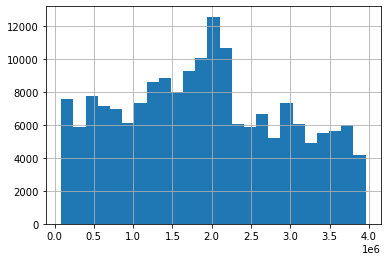

In [82]:
train.TransactionDT.hist(bins=25);

#### Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

#### Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

#### Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.